# Framework

## Instructions

Make sure you run this notebook with the same directory as the "Inference" folder.

Make sure you change all the directories within the notebook to your own (where you store the "Inference" folder).

In [1]:
pip install torchnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 7.5 MB/s eta 0:00:00
  Created wheel for torchnet: filename=torchnet-0.0.4-py3-none-any.whl size=29745 sha256=a9271f858c6e3e865e0ddfa32015e4f714e6b2c09bf029df6a53cf4a7659cd81
  Stored in directory: /root/.cache/pip/wheels/65/d2/1e/0c2519d1837089fe374a60ce10e120c555b9d77110a49f027f
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408216 sha256=a8bc60055c40fbf3a99a6a5513fce84bf45ce5772041172ef3a4c91d14586186
  Stored in directory: /root/.cache/pip/wheels/58/9e/14/30f7cc4dafdd4d602fb00ca33c6edd1424fc0f5df10a02e060
Successfully built torchnet visdom


In [2]:
pip install mplfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 KB 3.2 MB/s eta 0:00:00


In [3]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 23.3 MB/s eta 0:00:00


In [4]:
import os
import csv
import json
import pickle
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from mplfinance.original_flavor import candlestick2_ochl

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
from torchnet.dataset import TensorDataset
from torch.utils.data import TensorDataset as Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torchvision.models as models
import torchvision.transforms as transforms
from transformers import AutoModel, AutoTokenizer

from sklearn.metrics import f1_score, accuracy_score, matthews_corrcoef, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [5]:
import warnings
warnings.filterwarnings('ignore')

## Set Device

In [6]:
# set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available.")
else:
    device = torch.device("cpu")
    print("Using CPU.")

GPU is available.


## Preprocess Text Data

Files in the folder "Inference/sample tweets/sample stock" are the daily tweets of the sample stock.

We first load the tweets into a single DataFrame "df_tweet" where all the tweets in the previous 5 days corresponding to each target date were concatenated.

In [7]:
tweet_path = '/content/drive/MyDrive/Colab Notebooks/FML Project/Inference/sample tweets'

stocks, dates, tweets = [], [], []
for stock in os.listdir(tweet_path):
    if stock == '.DS_Store':
        continue
    folder_path = tweet_path + '/' + stock
    for file_name in tqdm(os.listdir(folder_path)):
        if '(1)' in file_name:
            print(file_name)
        tweet = ''
        file_path = folder_path + '/' + file_name
        with open(file_path, 'r') as f:
            for line in f:
                data = json.loads(line)
                tweet += ' '.join(data['text']) + '<sep>'
        stocks.append(stock)
        dates.append(file_name)
        tweets.append(tweet)

df_tweet = pd.DataFrame(columns=['stock', 'target_date', 'tweet'])
df_tweet['stock'] = stocks
df_tweet['target_date'] = dates
df_tweet['tweet'] = tweets
df_tweet['target_date'] = pd.to_datetime(df_tweet['target_date'])

df_tweet.head()

100%|██████████| 71/71 [00:11<00:00,  6.12it/s]


,stock,target_date,tweet
0,stock A,2014-05-14,$ abb abb ltd . ( adr ) ( nyse : abb ) high vo...
1,stock A,2014-04-13,$ abb : robert w . baird lowers rating to neut...
2,stock A,2015-07-22,reminder - $ abb goes ex-dividend soon $ inxx ...
3,stock A,2015-10-08,xlb energy select sector spdr summary URL $ xl...
4,stock A,2015-02-08,upgraded : $ abb $ rnr $ bsmx $ gm $ re $ slab...


## Generate Candlestick Charts and Labels

We load the historical stock prices from the "sample prices.csv" file and transform them into 5-day candlestick charts, as well as generating the corresponding labels (0 or 1).

In [8]:
def plot_candlestick(df, save_path, show_plot=True, fig_size=100, dpi=96):
    fig = plt.figure(figsize=(fig_size / (11 / 15) / dpi, fig_size / (11 / 15) / dpi), dpi=dpi)
    ax1 = fig.add_subplot(1, 1, 1)
    ax1.set_facecolor('black')
    ax1.figure.set_facecolor('k')
    candlestick2_ochl(ax1,
                      df['Open'], df['Close'], df['High'], df['Low'],
                      width=0.8, colorup='#77d879', colordown='#db3f3f')
    ax1.grid(False)
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)
    ax1.axis('off')

    if show_plot:
        plt.show()

    fig.savefig(save_path, pad_inches=0, transparent=False)
    plt.close(fig)

In [9]:
raw_price_path = '/content/drive/MyDrive/Colab Notebooks/FML Project/Inference/sample prices'

stock_names, N_raw = [], []
first = True
for file_name in os.listdir(raw_price_path):
    dates, open_prices, high_prices, low_prices, close_prices = [], [], [], [], []
    file_path = os.path.join(raw_price_path, file_name)
    df = pd.read_csv(file_path)
    df = df[df['Date'].between('2014-01-01', '2016-01-01')]
    stock_names.append(file_name.split('.')[0])
    df['Stock'] = len(df) * [file_name.split('.')[0]]
    if first:
        df_price = df
        first = False
    else:
        df_price = pd.concat([df_price, df])
    N_raw.append(len(df))
df_price = df_price.reset_index(drop=True)

df_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock
0,2014-01-02,26.170000,26.170000,25.780001,25.930000,22.476974,2720400,stock A
1,2014-01-03,26.110001,26.219999,26.049999,26.139999,22.659008,1084900,stock A
2,2014-01-06,25.740000,25.790001,25.670000,25.740000,22.312279,2434900,stock A
3,2014-01-07,25.709999,25.910000,25.680000,25.870001,22.424965,896200,stock A
4,2014-01-08,25.799999,25.910000,25.719999,25.840000,22.398958,1151200,stock A


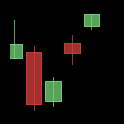

In [10]:
df = df_price[df_price['Stock'] == 'stock A'][20:25]
plot_candlestick(df, 'sample.png', show_plot=True)

In [11]:
for stock in stock_names:
    df_stock = df_price[df_price['Stock'] == stock]
    valid_dates, valid_labels = [], []
    for i in tqdm(range(len(df_stock))):
        if i + 5 >= len(df_stock):
            break
        diff = 100 * (df_stock.iloc[i + 5]['Adj Close'] - df_stock.iloc[i + 4]['Adj Close']) / df_stock.iloc[i + 4][
            'Adj Close']
        if diff <= -0.5:
            valid_label = 0
        elif diff >= 0.55:
            valid_label = 1
        else:
            continue
        valid_labels.append(valid_label)
        target_date = df_stock.iloc[i + 5]['Date']
        valid_dates.append(target_date)
        save_path = f'/content/drive/MyDrive/Colab Notebooks/FML Project/Inference/candlestick charts/{stock}@{target_date}#{valid_label}.png'
        plot_candlestick(df_stock[i:i+5], save_path, show_plot=False)

 99%|█████████▉| 499/504 [00:56<00:00,  8.78it/s]


Next, we generate a DataFrame to store the names of the candlestick charts and the corresponding target days and labels.

In [12]:
df_image = pd.DataFrame(columns=['stock', 'target_date'])

stock_names, target_dates, image_names, labels, features = [], [], [], [], []
for file_name in tqdm(os.listdir('/content/drive/MyDrive/Colab Notebooks/FML Project/Inference/candlestick charts')):
    stock_name = file_name.split('.')[0].split('@')[0]
    stock_names.append(stock_name)
    target_date = file_name.split('.')[0].split('@')[1].split('#')[0]
    target_dates.append(target_date)
    image_names.append(file_name)
    label = int(file_name.split('.')[0].split('#')[1])
    labels.append(label)

df_image['stock'] = stock_names
df_image['target_date'] = target_dates
df_image['image_name'] = image_names
df_image['label'] = labels
df_image['target_date'] = pd.to_datetime(df_image['target_date'])

df_image.head()

100%|██████████| 304/304 [00:00<00:00, 285569.63it/s]


,stock,target_date,image_name,label
0,stock A,2014-10-20,stock A@2014-10-20#1.png,1
1,stock A,2014-10-21,stock A@2014-10-21#1.png,1
2,stock A,2014-10-22,stock A@2014-10-22#1.png,1
3,stock A,2014-10-23,stock A@2014-10-23#1.png,1
4,stock A,2014-10-27,stock A@2014-10-27#0.png,0


Now, we load the generated candlestick charts as numpy arrays.

In [13]:
def load_candlestick(image_path, show_plot=True):
    img = Image.open(image_path)
    img = img.convert('RGB')
    crop_size = img.size[0] * 2/15
    img = img.crop((crop_size, crop_size, img.size[0]-crop_size, img.size[0]-crop_size))
    img = np.asarray(img)/255
    if show_plot:
        plt.imshow(img)
        plt.grid(False)
        plt.axis('off')
        plt.show()
    return img

In [14]:
image_path = '/content/drive/MyDrive/Colab Notebooks/FML Project/Inference/candlestick charts'

image_names, features = [], []

for file_name in tqdm(os.listdir(image_path)):
    image_file = image_path + '/' + file_name
    img = load_candlestick(image_file, show_plot=False)
    image_names.append(file_name)
    features.append(img)

100%|██████████| 304/304 [00:00<00:00, 503.97it/s]


## Merge and Align Text and Image Data

We now try to merge the text and image DataFrames we generated earlier to align the text and image data for the same target date.

In [15]:
tweets = []
for i in tqdm(range(len(df_image))):
    stock = df_image.iloc[i]['stock']
    target_date = df_image.iloc[i]['target_date']
    df_sub = df_tweet[df_tweet['stock']==stock]
    df_sub = df_sub[df_sub['target_date'].between(target_date-timedelta(days=5),target_date-timedelta(days=1))]
    if len(df_sub) > 0:
        tweet = '<sep>'.join(list(df_sub.tweet.values))
        tweets.append(tweet)
    else:
        tweets.append('')

100%|██████████| 304/304 [00:00<00:00, 671.34it/s]


In [16]:
df_image['tweet'] = tweets
df_merge = df_image[df_image['tweet'] != '']
df_merge = df_merge.sort_values(by=['stock', 'target_date'])
df_merge = df_merge.reindex(columns=['stock', 'target_date', 'image_name', 'tweet', 'label'])
df_merge.head()

,stock,target_date,image_name,tweet,label
109,stock A,2014-02-13,stock A@2014-02-13#0.png,"after a strong run , advanced energy industrie...",0
104,stock A,2014-02-14,stock A@2014-02-14#1.png,"after a strong run , advanced energy industrie...",1
199,stock A,2014-03-05,stock A@2014-03-05#1.png,abb ltd upgraded by citigroup inc . to buy . U...,1
196,stock A,2014-03-06,stock A@2014-03-06#1.png,abb ltd upgraded by citigroup inc . to buy . U...,1
229,stock A,2014-03-07,stock A@2014-03-07#0.png,abb ltd upgraded by citigroup inc . to buy . U...,0


In [17]:
df_features = pd.DataFrame(columns=['image_name', 'feature'])
df_features['image_name'] = image_names
df_features['feature'] = features
df_final = pd.merge(df_merge, df_features, on='image_name')

In [18]:
image_data = np.array(df_final.feature.tolist())
image_data.shape

(111, 100, 100, 3)

## Extract Image Features

We extract image features using the pre-trained ResNet50.

In [19]:
# load pre-traiend model
resnet = models.resnet50(pretrained=True)
modules = list(resnet.children())[:-1]
resnet = torch.nn.Sequential(*modules)
resnet.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 136MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [20]:
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

In [21]:
image_dataset = []
first = True
for image in tqdm(image_data):
    image_dataset.append(transform(Image.fromarray((image*255).astype(np.uint8))))

100%|██████████| 111/111 [00:00<00:00, 414.20it/s]


In [22]:
batch_size = 16
image_loader = DataLoader(image_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [23]:
image_features = []

resnet.eval()
for batch in tqdm(image_loader):
    with torch.no_grad():
        batch_features = resnet(batch.to(device))
        image_features.append(batch_features.cpu())

image_features = torch.cat(image_features, dim=0)
print(image_features.shape)

100%|██████████| 7/7 [00:07<00:00,  1.08s/it]

torch.Size([111, 2048, 1, 1])


In [24]:
image_features = image_features.squeeze()
image_features.shape

torch.Size([111, 2048])

## Extract Text Features

In [25]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [26]:
text_data = []
for i in tqdm(range(len(df_final))):
    tweets = df_final.iloc[i]['tweet'].split('<sep>')[:-1]
    tweets_concat = ' '.join(tweets)
    tokens = []
    for token in tweets_concat.split(' '):
        if token.isalpha() and token != 'URL' and token not in stop_words:
            tokens.append(token)
        if len(tokens) >= 256:
            break
    text_data.append(' '.join(tokens))

100%|██████████| 111/111 [00:00<00:00, 6074.34it/s]


In [30]:
# add for padding
text_data.append(('0 '*256)[:-1])

In [31]:
finbert = AutoModel.from_pretrained("ProsusAI/finbert").to(device)
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

Some weights of the model checkpoint at ProsusAI/finbert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
encoded_text = tokenizer.batch_encode_plus(list(text_data),
                                           padding=True,
                                           truncation=True,
                                           max_length=256,
                                           return_tensors='pt').to(device)

In [33]:
batch_size = 16
text_dataset = Dataset(encoded_text['input_ids'], encoded_text['attention_mask'])
text_loader = DataLoader(text_dataset, batch_size=batch_size)

In [34]:
text_features = []

finbert.eval()
for input_ids, attention_mask in tqdm(text_loader):
    with torch.no_grad():
        outputs = finbert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
    text_features.append(outputs.cpu())
    del outputs
    torch.cuda.empty_cache()

100%|██████████| 7/7 [00:01<00:00,  4.44it/s]


In [35]:
text_features = torch.cat(text_features, dim=0)
print('Text features shape: ', text_features.shape)

Text features shape:  torch.Size([112, 256, 768])


In [36]:
text_features = text_features[:-1]
print('Text features shape: ', text_features.shape)

Text features shape:  torch.Size([111, 256, 768])


## Dataset

In [37]:
labels = np.array(df_final.label)
len(labels)

dataset = TensorDataset([text_features.float(), image_features.float(), torch.tensor(labels).float()])
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

## Transformer-based Feature Fusion Model

In [38]:
class Text_Image_Transformer(nn.Module):
    """
    Bimodal (Text+Image) classifier based on self-supervised embeddings and cross-attention.
    """
    def __init__(self, params):
        super(Text_Image_Transformer, self).__init__()
        # multi-heads cross-attention
        self.mha_vt = nn.MultiheadAttention(embed_dim=params['hidden_size'],
                                            num_heads=params['vt_H'],
                                            dropout=params['vt_dropout'],
                                            batch_first=True)
        self.mha_tv = nn.MultiheadAttention(embed_dim=params['hidden_size'],
                                            num_heads=params['tv_H'],
                                            dropout=params['tv_dropout'],
                                            batch_first=True)

        # point-to-point feed-forward network
        self.feedforward = nn.Sequential(nn.Linear(params['hidden_size'], 2*params['hidden_size']),
                                         nn.ReLU(),
                                         nn.Linear(2*params['hidden_size'], params['hidden_size']))

        # functional layers
        self.relu = nn.ReLU()
        self.norm = nn.LayerNorm(params['hidden_size'])
        self.dropout_txt = nn.Dropout(p=params['txt_dropout'])
        self.dropout_img = nn.Dropout(p=params['img_dropout'])
        self.dropout = nn.Dropout(params['transformer_dropout'])

        # fully connected layers
        self.reduce_dim_txt = nn.Linear(in_features=params['txt_embed_size'],
                                        out_features=params['hidden_size'])
        self.reduce_dim_img = nn.Linear(in_features=params['img_embed_size'],
                                        out_features=params['hidden_size'])
        self.classifier = nn.Linear(in_features=params['hidden_size'],
                                    out_features=1)
        

    def forward(self, x_txt, x_img):
        """
        Input:
            x_txt   | text  self-supervised embeddings, shape = (batch_size, txt_embedding_size)
            x_img   | image self-supervised embeddings, shape = (batch_size, img_embedding_size)
        Output:
            y       | unnormalized logits, shape = (batch_size, 1)
            x_vt    | fused image-text features, shape = (batch_size, hidden_size)
        """
        # dimension reduction
        x_txt = self.reduce_dim_txt(x_txt)
        x_img = self.reduce_dim_img(x_img)
        # dropout
        x_txt = self.dropout_txt(x_txt)
        x_img = self.dropout_img(x_img)
        # inter-modality cross-attention
        x_vt, _ = self.mha_vt(x_img.unsqueeze(dim=1), x_txt, x_txt)
        x_tv, _ = self.mha_vt(x_txt, x_img.unsqueeze(dim=1), x_img.unsqueeze(dim=1))
        # residual connection and layer norm
        x_vt = self.norm(self.dropout(x_vt) + x_img.unsqueeze(dim=1))
        x_tv = self.norm(self.dropout(x_tv) + x_txt)
        # feed-forward network
        x_vt_ffn = self.feedforward(x_vt)
        x_tv_ffn = self.feedforward(x_tv)
        # residual connection and layer norm
        x_vt = self.norm(self.dropout(x_vt_ffn) + x_vt)
        x_tv = self.norm(self.dropout(x_tv_ffn) + x_tv)
        # temporal average as global representation
        x_tv = torch.mean(x_tv, dim=1)
        # fusion with Hadamard product
        x_fused = torch.mul(x_vt.squeeze(), x_tv.squeeze())
        # classification
        y = self.classifier(x_fused.squeeze())
        return y

In [39]:
model_params = {'txt_embed_size': 768,
                'img_embed_size': 2048,
                'hidden_size': 256,
                'txt_H': 4,
                'vt_H': 4,
                'tv_H': 4,
                'txt_dropout': 0.01,
                'img_dropout': 0.01,
                'vt_dropout': 0.01,
                'tv_dropout': 0.01,
                'fused_dropout': 0.01,
                'transformer_dropout': 0.01} 

model = Text_Image_Transformer(model_params)
weights = torch.load('/content/drive/MyDrive/Colab Notebooks/FML Project/Inference/Text_Image_Transformer.pt')
model.load_state_dict(weights)
model.to(device)

Text_Image_Transformer(
  (mha_vt): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (mha_tv): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (feedforward): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
  )
  (relu): ReLU()
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (dropout_txt): Dropout(p=0.01, inplace=False)
  (dropout_img): Dropout(p=0.01, inplace=False)
  (dropout): Dropout(p=0.01, inplace=False)
  (reduce_dim_txt): Linear(in_features=768, out_features=256, bias=True)
  (reduce_dim_img): Linear(in_features=2048, out_features=256, bias=True)
  (classifier): Linear(in_features=256, out_features=1, bias=True)
)

## Evaluation

In [40]:
def compute_accuracy(y_true, y_pred):
    assert (len(y_true) == len(y_pred))
    return accuracy_score(np.array(y_true), np.array(y_pred))

def compute_f1(y_true, y_pred):
    assert (len(y_true) == len(y_pred))
    return f1_score(np.array(y_true), np.array(y_pred))

def compute_MCC(y_true, y_pred):
    assert (len(y_true) == len(y_pred))
    return matthews_corrcoef(np.array(y_true), np.array(y_pred))

def evaluate_metrics(preds, labels):
    # labels = labels.cpu().numpy().tolist()
    # preds = torch.argmax(preds, dim=1).cpu().numpy().tolist()
    labels = [int(item) for item in labels]
    preds = [0 if item < 0.5 else 1 for item in preds]
    accuracy = compute_accuracy(labels, preds)
    f1 = compute_f1(labels, preds)
    mcc = compute_MCC(labels, preds)
    cm = confusion_matrix(labels, preds)
    return accuracy, f1, mcc, cm

In [41]:
test_preds, test_labels= [], []

model.eval()
f = nn.Sigmoid()

with torch.no_grad():
    for data in tqdm(data_loader):
        x_txt, x_img, labels = data[0].to(device), data[1].to(device), data[2].to(device)
        preds = model(x_txt, x_img)
        preds = f(preds).squeeze()
        test_preds.append(preds)
        test_labels.append(labels)
test_preds = torch.cat(test_preds)
test_labels = torch.cat(test_labels)

test_a, test_f1, test_mcc, test_cm = evaluate_metrics(test_preds, test_labels)

100%|██████████| 4/4 [00:00<00:00, 64.29it/s]


In [42]:
print('Text_Image_Transformer3')
print(25*'-')
print("Accuracy : {:.4f}".format(test_a))
print("F1-Score : {:.4f}".format(test_f1))
print("MCC Score: {:.4f}".format(test_mcc))

Text_Image_Transformer3
-------------------------
Accuracy : 0.5676
F1-Score : 0.3514
MCC Score: 0.1220


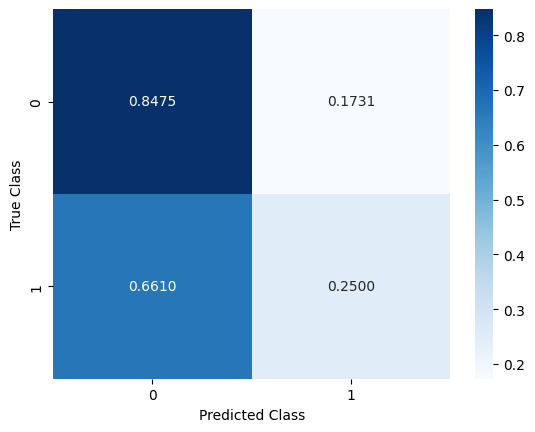

In [43]:
import seaborn as sns

normalized_cm = test_cm / test_cm.sum(axis=1)
sns.heatmap(normalized_cm, annot=True, fmt=".4f", cmap='Blues')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()